In [ ]:
!pip -q install --upgrade --no-cache-dir gdown

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageOps
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
# from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle
import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import Sequence

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -qq /content/drive/MyDrive/dataset_final/images_patches_filtered_train.zip -d /
!unzip -qq /content/drive/MyDrive/dataset_final/masks_patches_filtered_train.zip -d /

In [4]:
len(os.listdir('/content/images_patches'))

11022

In [ ]:
!nvidia-smi

Tue Jun 13 22:52:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    42W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#download masks_patches_filtered.zip
# !gdown 1-EkqDklIT6z2FpxuHk7RcSUFQv3C0pG3
#download images_patches_filtered_train.zip
!gdown 1hwr7genSo2FpRLpy_x0EnM376mWvV36r

!unzip -qq images_patches_filtered_train.zip -d /
# !unzip -qq masks_patches_filtered_train.zip -d /

In [5]:
root = '/content'
img_list = sorted(os.listdir(root + '/images_patches'))
mask_list = sorted(os.listdir(root + '/masks_patches/'))
df = pd.DataFrame()
cp = mask_list.copy()
df['slide_no'] = [ s[:s.find('_')] for s in cp]
cp = [ s[s.find('_')+1:] for s in cp]
df['region_no'] = [ s[:s.find('_')] for s in cp]
cp = [ s[s.find('_')+1:] for s in cp]
df['patch_position_x'] = [ s[:s.find('_')] for s in cp]
cp = [ s[s.find('_')+1:] for s in cp]
df['patch_position_y'] = [ s[:s.find('.')] for s in cp]
df['img_fullpath'] = [root+ "/images_patches/" + s for s in img_list]
df['mask_fullpath'] = [root+ "/masks_patches/" + s for s in mask_list]
w_list = list()
b_list = list()
w_rate_list = list()
for m_path in df['mask_fullpath']:
 m = cv2.imread(m_path,0)
 w = cv2.countNonZero(m)
 b = m.shape[0]*m.shape[1] - w
 w_rate = w / (m.shape[0]*m.shape[1])
 w_list.append(w)
 b_list.append(b)
 w_rate_list.append(w_rate)

df['whitepixels'] = w_list
df['blackpixels'] = b_list
df['whitepixels_rate'] = w_rate_list
df["epidermis_percentage"] = (df["whitepixels_rate"]*100).apply(np.ceil)



df_filtered = df.copy()
upper_th = df_filtered['epidermis_percentage']>=20
lower_th = df_filtered['epidermis_percentage']<=90

df_filtered = df_filtered[lower_th]
df_filtered = df_filtered[upper_th]
df_filtered.index = range(len(df_filtered))

df2 = df.groupby(by=["epidermis_percentage"]).count().reset_index()['slide_no']*100/len(df)
df_filtered2 = df_filtered.groupby(by=["epidermis_percentage"]).count().reset_index()['slide_no']*100/len(df_filtered)

df_filtered

<ipython-input-5-35afc179fb27>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered = df_filtered[upper_th]


slide_no region_no patch_position_x patch_position_y  \
0          01         0                0                0   
1          01         0                0                1   
2          01         0                0                2   
3          01         1                0                0   
4          01         1                0                1   
...       ...       ...              ...              ...   
5192       50         0                6                1   
5193       50         0                7                0   
5194       50         0                7                1   
5195       50         0                8                0   
5196       50         0                9                0   

                              img_fullpath  \
0     /content/images_patches/01_0_0_0.png   
1     /content/images_patches/01_0_0_1.png   
2     /content/images_patches/01_0_0_2.png   
3     /content/images_patches/01_1_0_0.png   
4     /content/images_patches/01_1_0_1.png   
...                                    ...   
5192  /content/images_patches/50_0_6_1.png   
5193  /content/images_patches/50_0_7_0.png   
5194  /content/images_patches/50_0_7_1.png   
5195  /content/images_patches/50_0_8_0.png   
5196  /content/images_patches/50_0_9_0.png   

                            mask_fullpath  whitepixels  blackpixels  \
0     /content/masks_patches/01_0_0_0.png        79868       182276   
1     /content/masks_patches/01_0_0_1.png        90675       171469   
2     /content/masks_patches/01_0_0_2.png        93041       169103   
3     /content/masks_patches/01_1_0_0.png       107013       155131   
4     /content/masks_patches/01_1_0_1.png       122773       139371   
...                                   ...          ...          ...   
5192  /content/masks_patches/50_0_6_1.png       160271       101873   
5193  /content/masks_patches/50_0_7_0.png        88323       173821   
5194  /content/masks_patches/50_0_7_1.png        89132       173012   
5195  /content/masks_patches/50_0_8_0.png       165774        96370   
5196  /content/masks_patches/50_0_9_0.png       185944        76200   

      whitepixels_rate  epidermis_percentage  
0             0.304672                  31.0  
1             0.345898                  35.0  
2             0.354923                  36.0  
3             0.408222                  41.0  
4             0.468342                  47.0  
...                ...                   ...  
5192          0.611385                  62.0  
5193          0.336926                  34.0  
5194          0.340012                  35.0  
5195          0.632378                  64.0  
5196          0.709320                  71.0  

[5197 rows x 10 columns]

In [6]:
df_filtered['epidermis_percentage'].min(),df_filtered['epidermis_percentage'].max()

(20.0, 90.0)

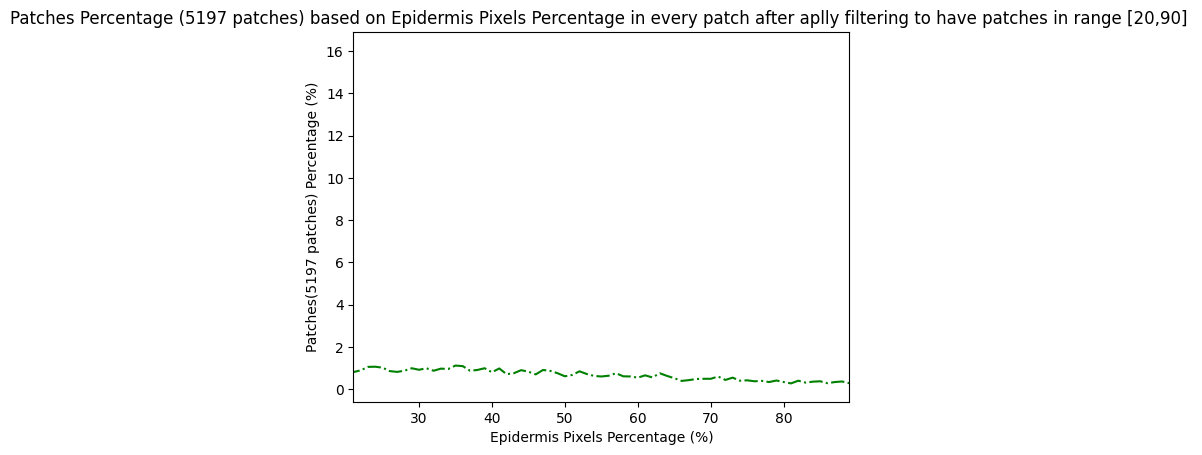

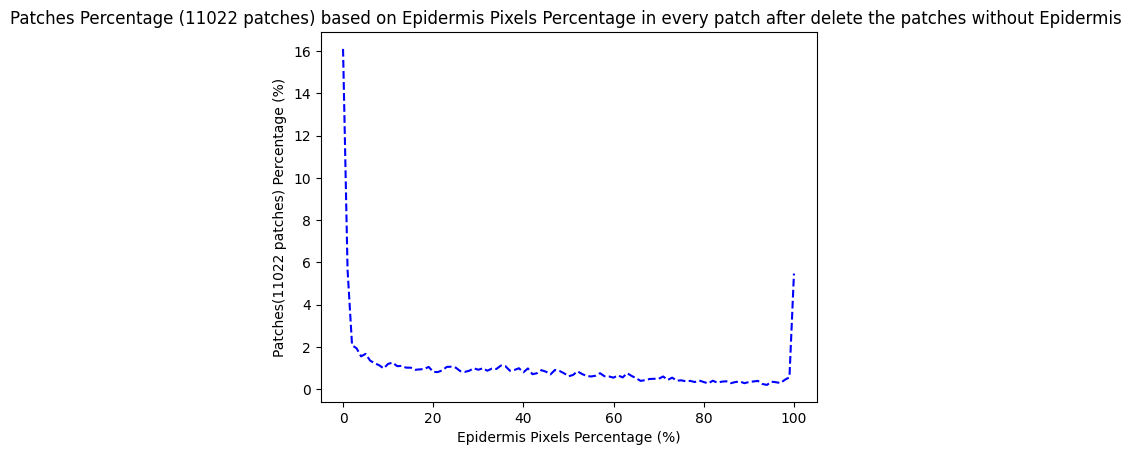

In [7]:
ax = plt.gca()
ax.set_xlabel("Epidermis Pixels Percentage (%)")
ax.set_ylabel('Patches('+str(len(df_filtered))+' patches) Percentage (%)')
df2.plot(kind = 'line', x = 'epidermis_percentage', y = 'slide_no', color = 'green',linestyle='-.',ax = ax)
plt.title('Patches Percentage ('+str(len(df_filtered))+' patches) based on Epidermis Pixels Percentage in every patch after aplly filtering to have patches in range [20,90] ')
ax.set_xlim(21, 89)
plt.show()
ax = plt.gca()
ax.set_xlabel("Epidermis Pixels Percentage (%)")
ax.set_ylabel('Patches('+str(len(df))+' patches) Percentage (%)')
df2.plot(kind = 'line', x = 'epidermis_percentage', y = 'slide_no', color = 'blue',linestyle='--',ax = ax)
plt.title('Patches Percentage ('+str(len(df))+' patches) based on Epidermis Pixels Percentage in every patch after delete the patches without Epidermis ')
plt.show()

In [8]:
def batchnorm_relu(inputs):
    """ Batch Normalization & ReLU """
    x = BatchNormalization()(inputs)
    x = Activation("relu")(x)
    return x

def residual_block(inputs, num_filters, strides=1):
    """ Convolutional Layers """
    x = batchnorm_relu(inputs)
    x = Conv2D(num_filters, 3, padding="same", strides=strides)(x)
    x = batchnorm_relu(x)
    x = Conv2D(num_filters, 3, padding="same", strides=1)(x)

    """ Shortcut Connection (Identity Mapping) """
    s = Conv2D(num_filters, 1, padding="same", strides=strides)(inputs)

    """ Addition """
    x = x + s
    return x

def decoder_block(inputs, skip_features, num_filters):
    """ Decoder Block """

    x = UpSampling2D((2, 2))(inputs)
    x = Concatenate()([x, skip_features])
    x = residual_block(x, num_filters, strides=1)
    return x

def build_resunet(input_shape):
    """ RESUNET Architecture """

    inputs = Input(input_shape)

    """ Endoder 1 """
    x = Conv2D(64, 3, padding="same", strides=1)(inputs)
    x = batchnorm_relu(x)
    x = Conv2D(64, 3, padding="same", strides=1)(x)
    s = Conv2D(64, 1, padding="same")(inputs)
    s1 = x + s

    """ Encoder 2, 3 """
    s2 = residual_block(s1, 128, strides=2)
    s3 = residual_block(s2, 256, strides=2)

    """ Bridge """
    b = residual_block(s3, 512, strides=2)

    """ Decoder 1, 2, 3 """
    x = decoder_block(b, s3, 256)
    x = decoder_block(x, s2, 128)
    x = decoder_block(x, s1, 64)

    """ Classifier """
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(x)

    """ Model """
    model = Model(inputs, outputs, name="RESUNET")

    return model

In [9]:
class DataGenerator(Sequence):
    def __init__(self, df, batch_size=8, image_size=(512, 512)):
        self.df = df
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    def __len__(self):
        return len(self.df) // self.batch_size

    def __getitem__(self, index):
        batch_df = self.df[index * self.batch_size: (index + 1) * self.batch_size]

        images = []
        masks = []
        for _, row in batch_df.iterrows():
            image_path = row['img_fullpath']
            mask_path = row['mask_fullpath']
            image = self.load_image(image_path)
            mask = self.load_mask(mask_path)
            images.append(image)
            masks.append(mask)

        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        self.df = self.df.sample(frac=1).reset_index(drop=True)

    def load_image(self, image_path):
        image = Image.open(image_path)
        image = np.array(image)
        image = image / 255.0
        return image

    def load_mask(self, mask_path):
        mask = Image.open(mask_path)
        mask = ImageOps.grayscale(mask)
        mask = np.expand_dims(mask, axis=-1)
        mask = mask / 255.0
        return mask



In [10]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='resunet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',np.round(logs.get('loss'),4),'val_loss=',np.round(logs.get('val_loss'),4),'mean_iou=',np.round(logs.get('mean_iou'),4),'val_mean_iou=',np.round(logs.get('val_mean_iou'),4))

        #choose a random test image and preprocess
        j = np.random.choice(val_df.index.values)
        raw = Image.open(val_df.iloc[j]['img_fullpath'])
        ground_truth = Image.open(val_df.iloc[j]['mask_fullpath'])
        raw = np.array(raw.resize((512, 512)))/255.
        ground_truth = np.array(ground_truth.resize((512, 512)))/255.
        raw = raw[:,:,0:3]

        #predict the mask
        pred = model.predict(np.expand_dims(raw, 0))

        #mask post-processing
        pred_msk  = pred.squeeze()
        pred_msk = np.stack((pred_msk,)*3, axis=-1)

        pred_msk[pred_msk >= 0.5] = 1
        pred_msk[pred_msk < 0.5] = 0

        ground_truth = np.stack((ground_truth,)*3, axis=-1)
        #show the mask and the segmented image

        combined = np.concatenate([raw, pred_msk, raw* pred_msk,raw*ground_truth], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

In [ ]:
def dice_loss(y_true, y_pred):
    smooth = 1e-5
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    dice_coef = K.mean((2.0 * intersection + smooth) / (union + smooth), axis=0)
    return 1.0 - dice_coef


In [11]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [12]:
input_shape = (512, 512, 3)
model = build_resunet(input_shape)

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

train_df.index = range(len(train_df))
val_df.index = range(len(val_df))

model.summary()



Model: "RESUNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                           

Epoch 1/60
   6/1102 [..............................] - ETA: 5:45 - loss: 68.1150 - mean_iou: 0.1603

1/1 [==============================] - 1s 1s/step


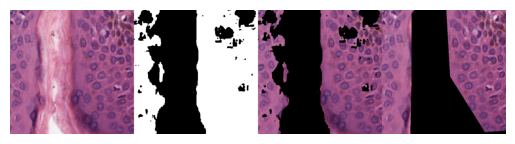

1102/1102 [==============================] - 431s 352ms/step - loss: 0.9856 - mean_iou: 0.4992 - val_loss: 1.1684 - val_mean_iou: 0.1481
Epoch 2/60
1/1 [==============================] - 0s 23ms/step


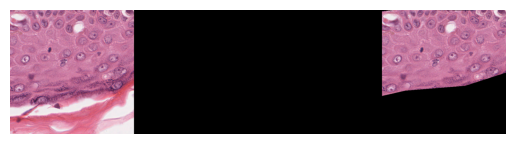

1102/1102 [==============================] - 374s 339ms/step - loss: 0.3760 - mean_iou: 0.5960 - val_loss: 1.8386 - val_mean_iou: 0.0358
Epoch 3/60
1/1 [==============================] - 0s 23ms/step


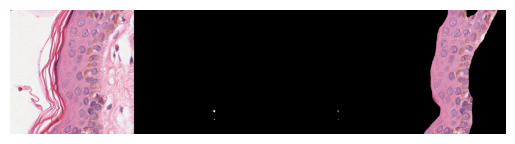

1102/1102 [==============================] - 374s 339ms/step - loss: 0.3481 - mean_iou: 0.6234 - val_loss: 0.5025 - val_mean_iou: 0.4021
Epoch 4/60
1/1 [==============================] - 0s 23ms/step


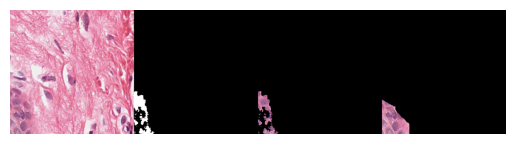

1102/1102 [==============================] - 374s 339ms/step - loss: 0.3260 - mean_iou: 0.6477 - val_loss: 0.3244 - val_mean_iou: 0.6475
Epoch 5/60
1/1 [==============================] - 0s 23ms/step


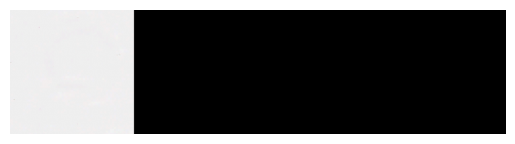

1102/1102 [==============================] - 374s 339ms/step - loss: 0.3119 - mean_iou: 0.6625 - val_loss: 0.6026 - val_mean_iou: 0.1007
Epoch 6/60
1/1 [==============================] - 0s 23ms/step


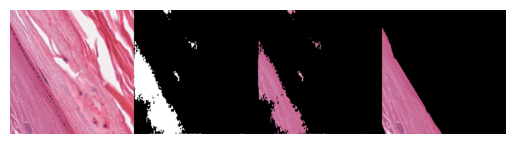

1102/1102 [==============================] - 374s 339ms/step - loss: 0.2956 - mean_iou: 0.6715 - val_loss: 0.3728 - val_mean_iou: 0.5461
Epoch 7/60
1/1 [==============================] - 0s 23ms/step


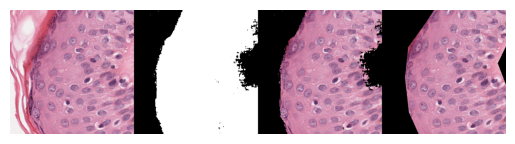

1102/1102 [==============================] - 374s 339ms/step - loss: 0.2841 - mean_iou: 0.6802 - val_loss: 0.3689 - val_mean_iou: 0.6870
Epoch 8/60
1/1 [==============================] - 0s 23ms/step


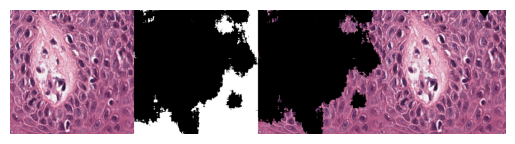

1102/1102 [==============================] - 374s 339ms/step - loss: 0.2761 - mean_iou: 0.6893 - val_loss: 1.0938 - val_mean_iou: 0.2507
Epoch 9/60
1/1 [==============================] - 0s 23ms/step


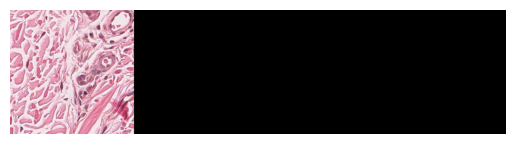

1102/1102 [==============================] - 374s 339ms/step - loss: 0.2686 - mean_iou: 0.6984 - val_loss: 0.3282 - val_mean_iou: 0.6807
Epoch 10/60
1/1 [==============================] - 0s 23ms/step


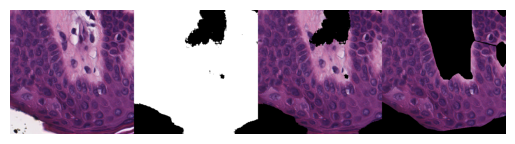

1102/1102 [==============================] - 374s 339ms/step - loss: 0.2637 - mean_iou: 0.7038 - val_loss: 0.2831 - val_mean_iou: 0.6951
Epoch 11/60
1/1 [==============================] - 0s 25ms/step


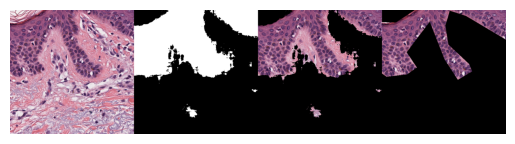

1102/1102 [==============================] - 374s 340ms/step - loss: 0.2592 - mean_iou: 0.7099 - val_loss: 0.3088 - val_mean_iou: 0.7097
Epoch 12/60
1/1 [==============================] - 0s 24ms/step


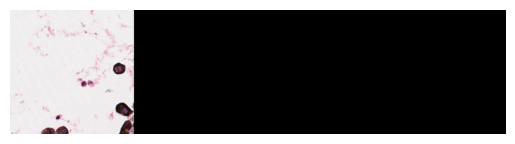

1102/1102 [==============================] - 374s 340ms/step - loss: 0.2527 - mean_iou: 0.7165 - val_loss: 0.3220 - val_mean_iou: 0.5957
Epoch 13/60
1/1 [==============================] - 0s 26ms/step


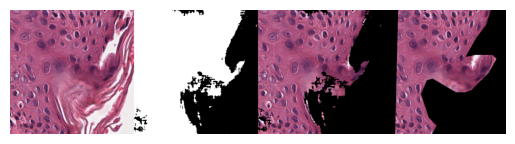

1102/1102 [==============================] - 374s 339ms/step - loss: 0.2471 - mean_iou: 0.7236 - val_loss: 0.3496 - val_mean_iou: 0.5317
Epoch 14/60
1/1 [==============================] - 0s 26ms/step


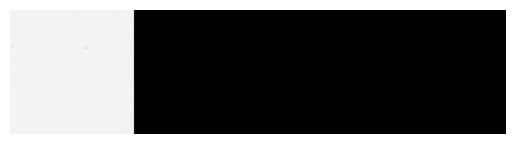

1102/1102 [==============================] - 375s 340ms/step - loss: 0.2417 - mean_iou: 0.7277 - val_loss: 0.6203 - val_mean_iou: 0.3992
Epoch 15/60
1/1 [==============================] - 0s 26ms/step


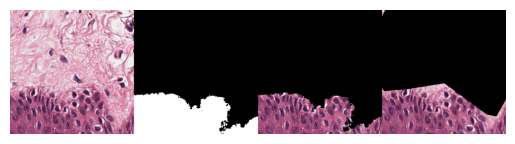

1102/1102 [==============================] - 374s 340ms/step - loss: 0.2386 - mean_iou: 0.7321 - val_loss: 0.3200 - val_mean_iou: 0.7012
Epoch 16/60
1/1 [==============================] - 0s 26ms/step


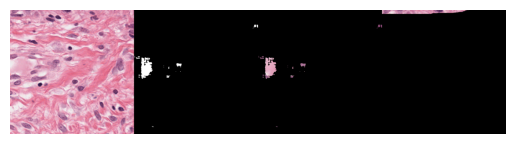

1102/1102 [==============================] - 375s 340ms/step - loss: 0.2362 - mean_iou: 0.7371 - val_loss: 0.2732 - val_mean_iou: 0.6866
Epoch 17/60
1/1 [==============================] - 0s 25ms/step


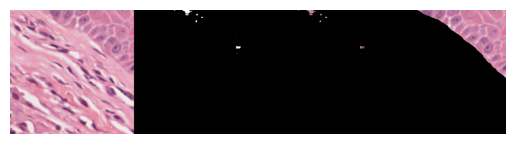

1102/1102 [==============================] - 374s 340ms/step - loss: 0.2315 - mean_iou: 0.7403 - val_loss: 0.3743 - val_mean_iou: 0.5276
Epoch 18/60
1/1 [==============================] - 0s 25ms/step


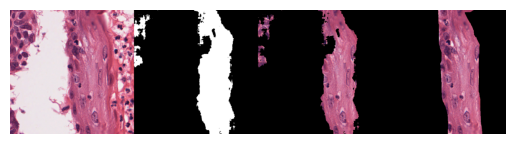

1102/1102 [==============================] - 374s 340ms/step - loss: 0.2290 - mean_iou: 0.7422 - val_loss: 0.2732 - val_mean_iou: 0.6843
Epoch 19/60
1/1 [==============================] - 0s 27ms/step


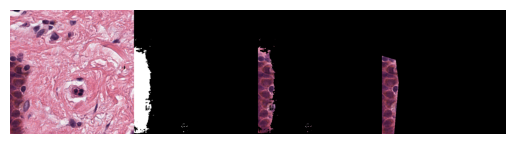

1102/1102 [==============================] - 374s 340ms/step - loss: 0.2278 - mean_iou: 0.7454 - val_loss: 0.3411 - val_mean_iou: 0.5520
Epoch 20/60
1/1 [==============================] - 0s 26ms/step


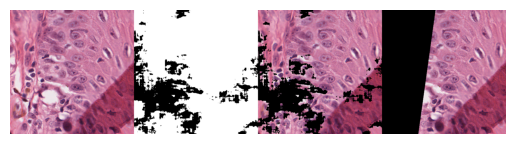

1102/1102 [==============================] - 374s 340ms/step - loss: 0.2228 - mean_iou: 0.7492 - val_loss: 0.2598 - val_mean_iou: 0.7334
Epoch 21/60
1/1 [==============================] - 0s 27ms/step


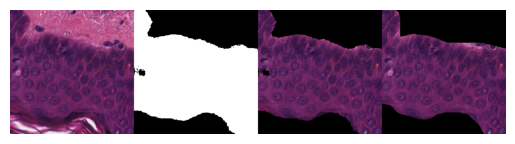

1102/1102 [==============================] - 374s 340ms/step - loss: 0.2210 - mean_iou: 0.7518 - val_loss: 0.3223 - val_mean_iou: 0.7076
Epoch 22/60
1/1 [==============================] - 0s 26ms/step


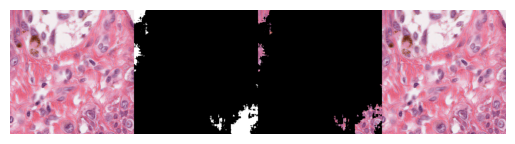

1102/1102 [==============================] - 374s 340ms/step - loss: 0.2208 - mean_iou: 0.7524 - val_loss: 0.2768 - val_mean_iou: 0.6938
Epoch 23/60
1/1 [==============================] - 0s 25ms/step


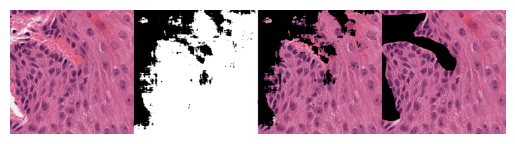

1102/1102 [==============================] - 374s 340ms/step - loss: 0.2142 - mean_iou: 0.7594 - val_loss: 0.2575 - val_mean_iou: 0.7108
Epoch 24/60
1/1 [==============================] - 0s 25ms/step


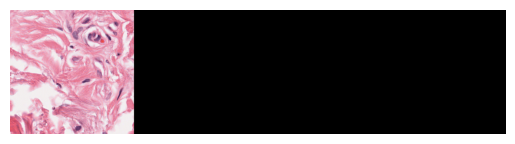

1102/1102 [==============================] - 374s 340ms/step - loss: 0.2143 - mean_iou: 0.7581 - val_loss: 0.5107 - val_mean_iou: 0.3865
Epoch 25/60
1/1 [==============================] - 0s 25ms/step


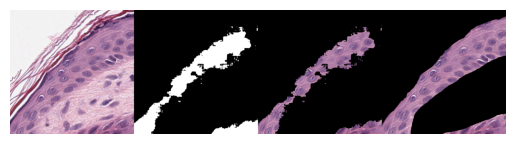

1102/1102 [==============================] - 374s 340ms/step - loss: 0.2113 - mean_iou: 0.7640 - val_loss: 0.3532 - val_mean_iou: 0.6602
Epoch 26/60
1/1 [==============================] - 0s 23ms/step


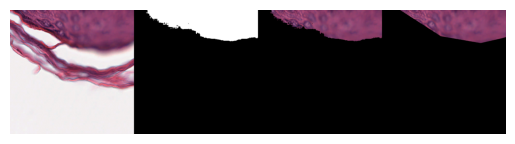

1102/1102 [==============================] - 374s 340ms/step - loss: 0.2069 - mean_iou: 0.7663 - val_loss: 0.3014 - val_mean_iou: 0.6950
Epoch 27/60
1/1 [==============================] - 0s 25ms/step


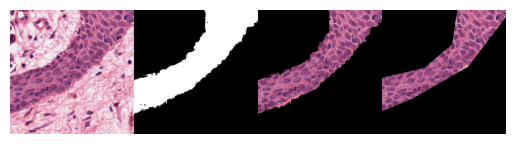

1102/1102 [==============================] - 374s 340ms/step - loss: 0.2051 - mean_iou: 0.7701 - val_loss: 0.2444 - val_mean_iou: 0.7482
Epoch 28/60
1/1 [==============================] - 0s 23ms/step


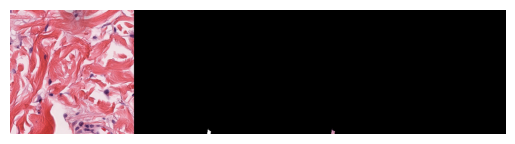

1102/1102 [==============================] - 373s 339ms/step - loss: 0.2052 - mean_iou: 0.7692 - val_loss: 0.3803 - val_mean_iou: 0.4144
Epoch 29/60
1/1 [==============================] - 0s 23ms/step


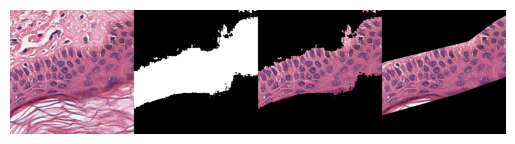

1102/1102 [==============================] - 373s 339ms/step - loss: 0.2014 - mean_iou: 0.7731 - val_loss: 0.2928 - val_mean_iou: 0.6785
Epoch 30/60
1/1 [==============================] - 0s 23ms/step


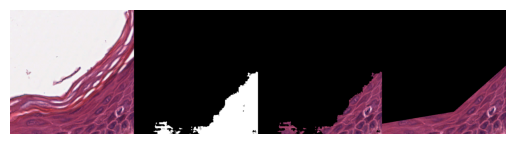

1102/1102 [==============================] - 374s 339ms/step - loss: 0.1983 - mean_iou: 0.7736 - val_loss: 0.3598 - val_mean_iou: 0.5727
Epoch 31/60
1/1 [==============================] - 0s 23ms/step


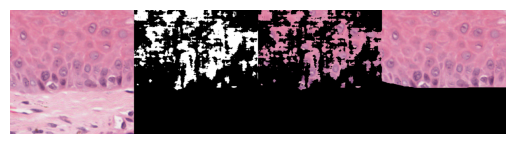

1102/1102 [==============================] - 374s 339ms/step - loss: 0.1978 - mean_iou: 0.7777 - val_loss: 0.2941 - val_mean_iou: 0.6646
Epoch 32/60
1/1 [==============================] - 0s 22ms/step


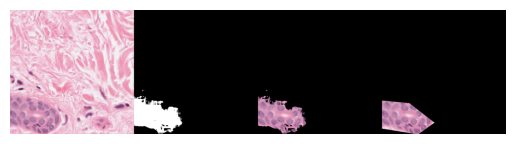

1102/1102 [==============================] - 374s 339ms/step - loss: 0.1934 - mean_iou: 0.7819 - val_loss: 0.2270 - val_mean_iou: 0.7511
Epoch 33/60
1/1 [==============================] - 0s 23ms/step


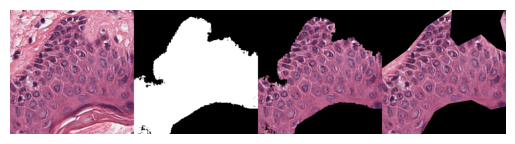

1102/1102 [==============================] - 374s 339ms/step - loss: 0.1931 - mean_iou: 0.7811 - val_loss: 0.4163 - val_mean_iou: 0.4980
Epoch 34/60
1/1 [==============================] - 0s 23ms/step


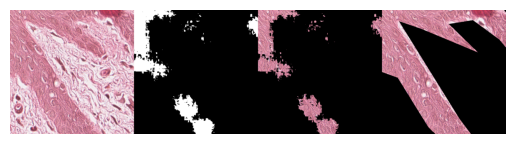

1102/1102 [==============================] - 374s 339ms/step - loss: 0.1906 - mean_iou: 0.7826 - val_loss: 0.6311 - val_mean_iou: 0.2925
Epoch 35/60
1/1 [==============================] - 0s 24ms/step


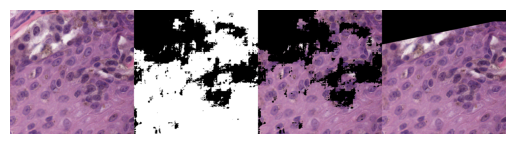

1102/1102 [==============================] - 373s 339ms/step - loss: 0.1890 - mean_iou: 0.7855 - val_loss: 0.3497 - val_mean_iou: 0.6288
Epoch 36/60
1/1 [==============================] - 0s 23ms/step


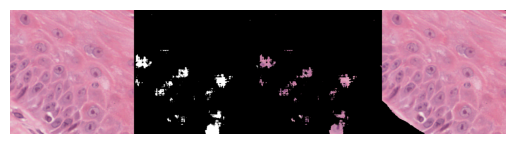

1102/1102 [==============================] - 374s 339ms/step - loss: 0.1885 - mean_iou: 0.7867 - val_loss: 0.2933 - val_mean_iou: 0.6463
Epoch 37/60
1/1 [==============================] - 0s 22ms/step


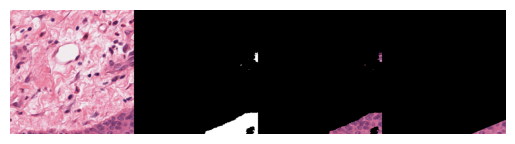

1102/1102 [==============================] - 374s 339ms/step - loss: 0.1847 - mean_iou: 0.7903 - val_loss: 0.5753 - val_mean_iou: 0.4383
Epoch 38/60
1/1 [==============================] - 0s 23ms/step


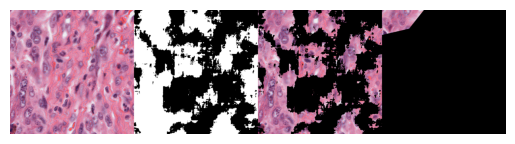

1102/1102 [==============================] - 374s 339ms/step - loss: 0.1829 - mean_iou: 0.7927 - val_loss: 0.2544 - val_mean_iou: 0.7272
Epoch 39/60
1/1 [==============================] - 0s 23ms/step


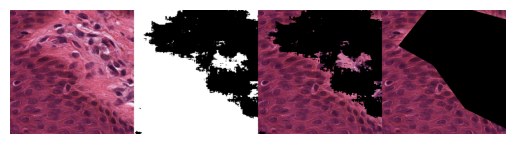

1102/1102 [==============================] - 374s 339ms/step - loss: 0.1808 - mean_iou: 0.7936 - val_loss: 0.2465 - val_mean_iou: 0.7308
Epoch 40/60
1/1 [==============================] - 0s 23ms/step


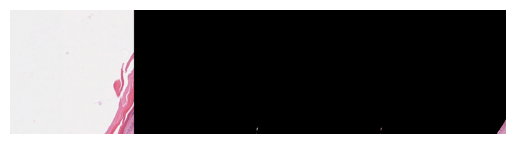

1102/1102 [==============================] - 374s 339ms/step - loss: 0.1806 - mean_iou: 0.7948 - val_loss: 0.2457 - val_mean_iou: 0.7177
Epoch 41/60
1/1 [==============================] - 0s 23ms/step


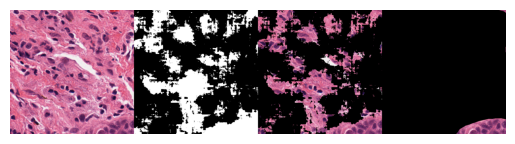

1102/1102 [==============================] - 374s 339ms/step - loss: 0.1788 - mean_iou: 0.7976 - val_loss: 0.3478 - val_mean_iou: 0.7161
Epoch 42/60
1/1 [==============================] - 0s 24ms/step


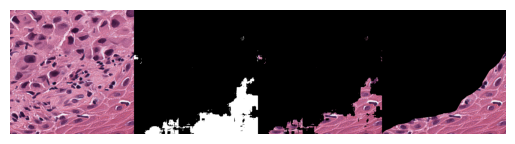

1102/1102 [==============================] - 374s 339ms/step - loss: 0.1773 - mean_iou: 0.7983 - val_loss: 0.2969 - val_mean_iou: 0.6681
Epoch 43/60
1/1 [==============================] - 0s 24ms/step


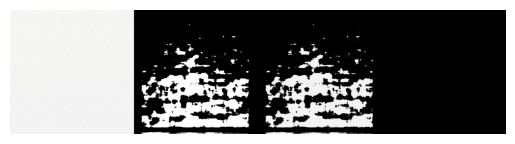

1102/1102 [==============================] - 374s 339ms/step - loss: 0.1756 - mean_iou: 0.7993 - val_loss: 0.4677 - val_mean_iou: 0.4800
Epoch 44/60
1/1 [==============================] - 0s 28ms/step


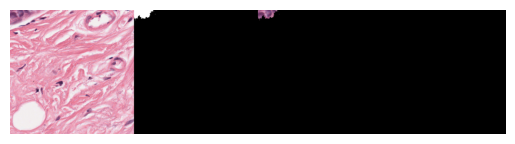

1102/1102 [==============================] - 374s 339ms/step - loss: 0.1735 - mean_iou: 0.8027 - val_loss: 0.2031 - val_mean_iou: 0.7772
Epoch 45/60
1/1 [==============================] - 0s 24ms/step


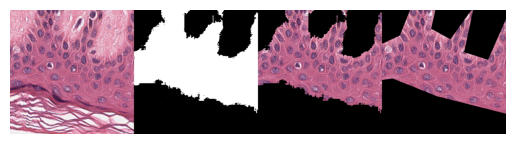

1102/1102 [==============================] - 374s 339ms/step - loss: 0.1707 - mean_iou: 0.8023 - val_loss: 0.3007 - val_mean_iou: 0.6700
Epoch 46/60
1/1 [==============================] - 0s 23ms/step


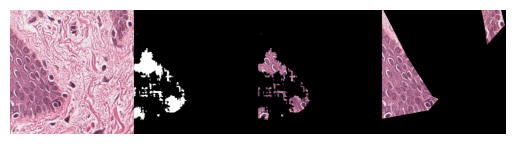

1102/1102 [==============================] - 374s 339ms/step - loss: 0.1709 - mean_iou: 0.8035 - val_loss: 0.4180 - val_mean_iou: 0.3975
Epoch 47/60
1/1 [==============================] - 0s 24ms/step


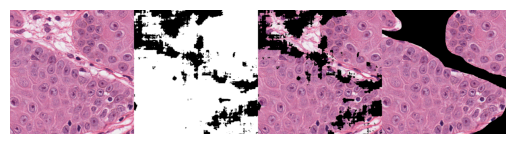

1102/1102 [==============================] - 374s 339ms/step - loss: 0.1697 - mean_iou: 0.8058 - val_loss: 0.8471 - val_mean_iou: 0.4456
Epoch 48/60
1/1 [==============================] - 0s 25ms/step


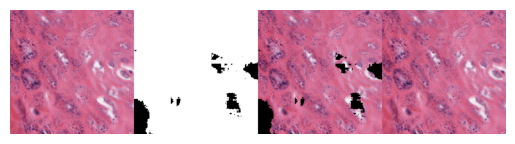

1102/1102 [==============================] - 374s 339ms/step - loss: 0.1664 - mean_iou: 0.8077 - val_loss: 0.2193 - val_mean_iou: 0.7672
Epoch 49/60
1/1 [==============================] - 0s 23ms/step


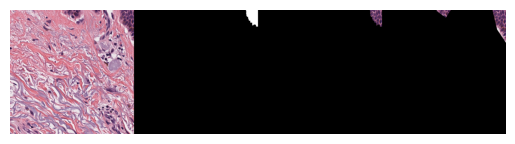

1102/1102 [==============================] - 374s 339ms/step - loss: 0.1659 - mean_iou: 0.8087 - val_loss: 0.2604 - val_mean_iou: 0.7159
Epoch 50/60
1/1 [==============================] - 0s 23ms/step


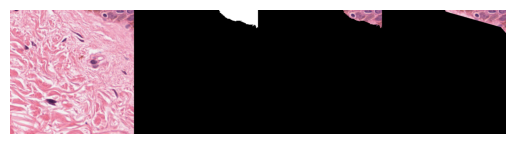

1102/1102 [==============================] - 374s 339ms/step - loss: 0.1658 - mean_iou: 0.8090 - val_loss: 0.2152 - val_mean_iou: 0.7856
Epoch 51/60
1/1 [==============================] - 0s 24ms/step


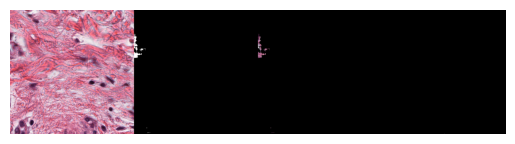

1102/1102 [==============================] - 374s 339ms/step - loss: 0.1640 - mean_iou: 0.8102 - val_loss: 0.3911 - val_mean_iou: 0.5766
Epoch 52/60
1/1 [==============================] - 0s 23ms/step


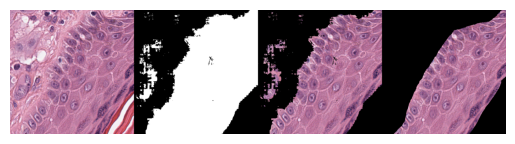

1102/1102 [==============================] - 374s 339ms/step - loss: 0.1601 - mean_iou: 0.8118 - val_loss: 0.2499 - val_mean_iou: 0.7355
Epoch 53/60
1/1 [==============================] - 0s 23ms/step


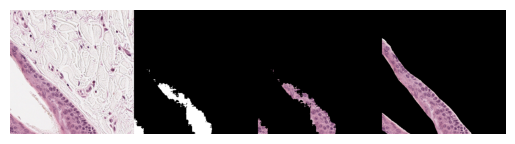

1102/1102 [==============================] - 374s 339ms/step - loss: 0.1585 - mean_iou: 0.8156 - val_loss: 0.2320 - val_mean_iou: 0.7557
Epoch 54/60
1/1 [==============================] - 0s 23ms/step


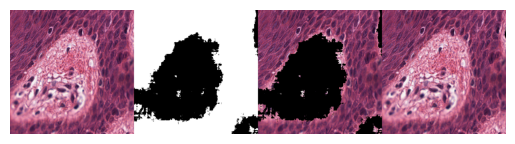

1102/1102 [==============================] - 374s 339ms/step - loss: 0.1571 - mean_iou: 0.8176 - val_loss: 0.2486 - val_mean_iou: 0.7336
Epoch 55/60
1/1 [==============================] - 0s 24ms/step


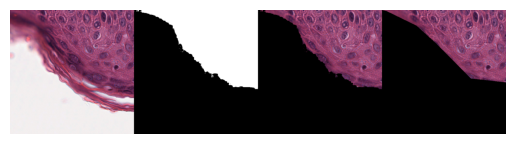

1102/1102 [==============================] - 374s 339ms/step - loss: 0.1545 - mean_iou: 0.8188 - val_loss: 0.2093 - val_mean_iou: 0.7702
Epoch 56/60
1/1 [==============================] - 0s 23ms/step


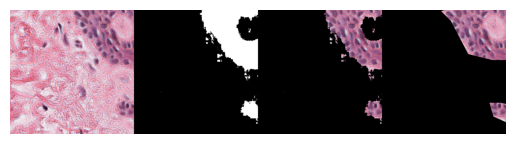

1102/1102 [==============================] - 374s 339ms/step - loss: 0.1516 - mean_iou: 0.8226 - val_loss: 0.2186 - val_mean_iou: 0.7666
Epoch 57/60
1/1 [==============================] - 0s 23ms/step


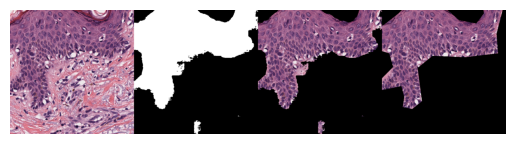

1102/1102 [==============================] - 374s 339ms/step - loss: 0.1498 - mean_iou: 0.8239 - val_loss: 0.2054 - val_mean_iou: 0.7729
Epoch 58/60
1/1 [==============================] - 0s 23ms/step


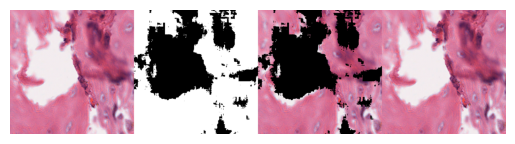

1102/1102 [==============================] - 374s 339ms/step - loss: 0.1500 - mean_iou: 0.8241 - val_loss: 0.2317 - val_mean_iou: 0.7497
Epoch 59/60
1/1 [==============================] - 0s 23ms/step


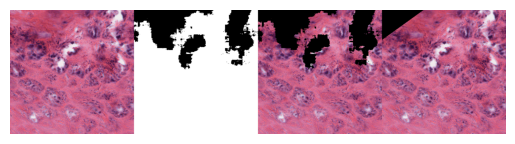

1102/1102 [==============================] - 374s 339ms/step - loss: 0.1472 - mean_iou: 0.8265 - val_loss: 0.2384 - val_mean_iou: 0.7724
Epoch 60/60
1/1 [==============================] - 0s 24ms/step


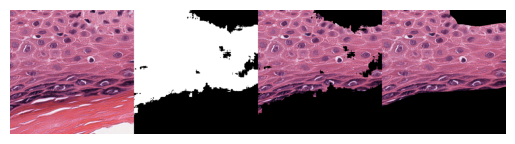

1102/1102 [==============================] - 374s 339ms/step - loss: 0.1431 - mean_iou: 0.8302 - val_loss: 0.1873 - val_mean_iou: 0.7955


In [13]:
epochs = 60
batch_size = 256
train_generator = DataGenerator(train_df)
val_generator = DataGenerator(val_df)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[mean_iou])
history = model.fit(train_generator, validation_data=val_generator, callbacks=build_callbacks(), epochs=epochs, batch_size=batch_size)


In [15]:
model.save('/content/drive/MyDrive/dataset_final/models/res_unet_100_0.h5');

In [ ]:
model.summary()

In [16]:
history.history


{'loss': [0.9855797290802002,
  0.3759790062904358,
  0.3481488823890686,
  0.32598868012428284,
  0.3119143843650818,
  0.2955520451068878,
  0.28411543369293213,
  0.27605003118515015,
  0.268627405166626,
  0.26368966698646545,
  0.25918126106262207,
  0.25273603200912476,
  0.24710679054260254,
  0.2417236715555191,
  0.23861932754516602,
  0.23620808124542236,
  0.23148483037948608,
  0.22897742688655853,
  0.22783973813056946,
  0.2227807492017746,
  0.2210189402103424,
  0.22080771625041962,
  0.21421733498573303,
  0.21429802477359772,
  0.21132059395313263,
  0.20692448318004608,
  0.20514097809791565,
  0.2051776498556137,
  0.20141883194446564,
  0.19834817945957184,
  0.19779622554779053,
  0.19344280660152435,
  0.19308388233184814,
  0.1906059831380844,
  0.18897303938865662,
  0.18847200274467468,
  0.1846662163734436,
  0.1828790009021759,
  0.1808251440525055,
  0.18057766556739807,
  0.17878860235214233,
  0.1773412674665451,
  0.17559151351451874,
  0.173549741506576

In [20]:
import json
with open("history_res_unet_100_0.json", "w") as outfile:
    json.dump(history.history, outfile)

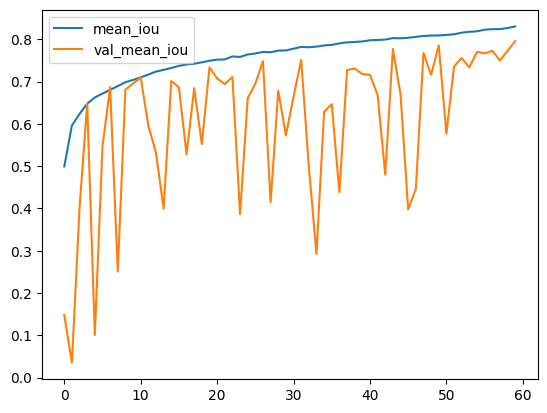

In [18]:
plt.plot(history.history['mean_iou'])
plt.plot(history.history['val_mean_iou'])
plt.legend(['mean_iou', 'val_mean_iou'])
plt.show()

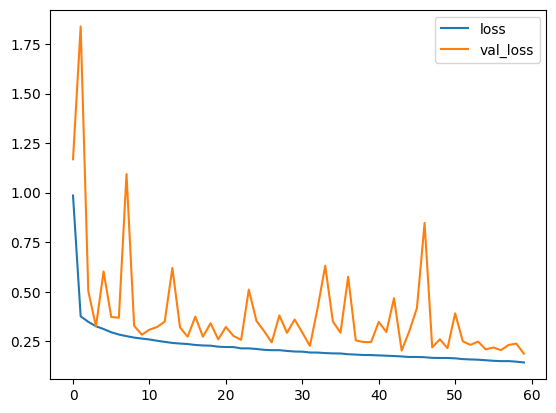

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
!cp /content/VGG_unet_filtered.h5 /content/drive/MyDrive/dataset_final/final_training_res/20230608_training_VGG-unet_filtered/VGG_unet_filtered.h5
!cp /content/history_VGG_unet_filtered.json /content/drive/MyDrive/dataset_final/final_training_res/20230608_training_VGG-unet_filtered/history_VGG_unet_filtered.json